# Inflação IPCA — Brasil (BACEN/SGS 433)

Gerado em 2025-10-26.

Variação mensal do IPCA (%, mensal) — índice oficial de inflação ao consumidor (IBGE), via SGS 433.

# **1. Importar as bibliotecas**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.7 MB/s eta 0:00:00


In [4]:
!pip uninstall -y numpy pmdarima scikit-learn Cython
!pip install numpy==1.26.4 scikit-learn==1.3.2 Cython==3.0.10 pmdarima==2.0.4 --no-cache-dir

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: Cython 3.0.12
Uninstalling Cython-3.0.12:
  Successfully uninstalled Cython-3.0.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 323.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 275.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 316.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 325.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [2]:
from pmdarima import auto_arima

# **2. Pré-Processamento dos dados**

## **2.1 - Input dos dados**

In [4]:
df = pd.read_csv('/content/03_Inflacao_BR.csv')
df.head()

,date,value
0,1980-02-01,462.0
1,1980-03-01,604.0
2,1980-04-01,529.0
3,1980-05-01,570.0
4,1980-06-01,531.0


## **2.2 - Indexamento da coluna "date"**

In [5]:
# Converter a coluna 'date' para o formato datetime
df['date'] = pd.to_datetime(df['date'])

# Definir a coluna 'date' como o índice do DataFrame
df.set_index('date', inplace=True)

print("--- Informações do DataFrame Pós-Processamento ---")
df.info()
print("\n--- Head do DataFrame com DatetimeIndex ---")
print(df.head())

--- Informações do DataFrame Pós-Processamento ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1980-02-01 to 2025-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   548 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB

--- Head do DataFrame com DatetimeIndex ---
            value
date             
1980-02-01  462.0
1980-03-01  604.0
1980-04-01  529.0
1980-05-01  570.0
1980-06-01  531.0


## **2.3 - Visualização da serie temporal**

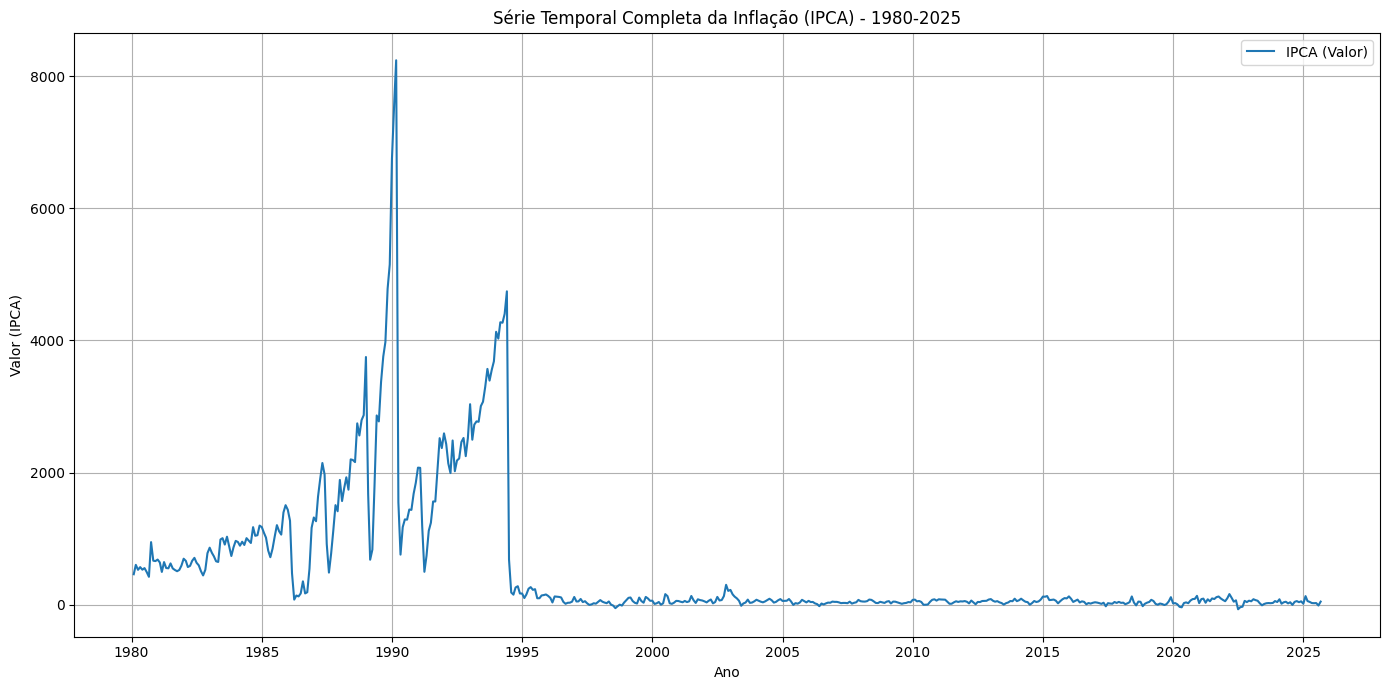

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['value'], label='IPCA (Valor)')
plt.title('Série Temporal Completa da Inflação (IPCA) - 1980-2025')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()

### **Análise da Visualização (1980-2025):**
A série é dominada por valores absurdamente altos no período pré-1994 (hiperinflação). Os valores pós-1994 são tão pequenos em comparação que a linha do gráfico parece estar "achatada" no eixo zero.

O processo que gerava a inflação em 1988 (centenas ou milhares por cento ao mês) não tem nenhuma relação com o processo que gera a inflação em 2024 (dígitos únicos ao ano).


### **Metodológica:**
Seria incorreto tentar usar a série inteira. Poderíamos tentar aplicar transformações (ex: log) e múltiplas diferenciações (d=2 ou d=3 no ARIMA) para "forçar" a estacionariedade. No entanto, o modelo resultante estaria tentando aprender com padrões que não existem mais. Além disso, a premissa de homocedasticidade (variância constante) é violada de forma extrema.


Por isso, **optamos por "Fatiar" a serie**. Vamos usar apenas o período em que o regime econômico é estável e relevante para o futuro. O Plano Real foi implementado em julho de 1994. Para garantir que pegamos um período onde a nova moeda já estava estabilizada, vamos definir nossa data de início em 1º de Janeiro de 1995.


Nosso objetivo de prever os próximos 12 meses (2025-2026) deve ser baseado no comportamento da inflação da era moderna (1995-2025).

## **2.4 - Fatiamento do dataframe**

In [7]:
start_date = '1995-01-01'
df_pos_real = df.loc[start_date:].copy()

print(f"--- Análise do Período Pós-Plano Real ---")
print(f"Dados selecionados a partir de: {start_date}")
print(f"Número de observações original: {len(df)}")
print(f"Número de observações no novo DataFrame: {len(df_pos_real)}")

--- Análise do Período Pós-Plano Real ---
Dados selecionados a partir de: 1995-01-01
Número de observações original: 548
Número de observações no novo DataFrame: 369


## **2.5 - Visualização da serie após o fatiamento**

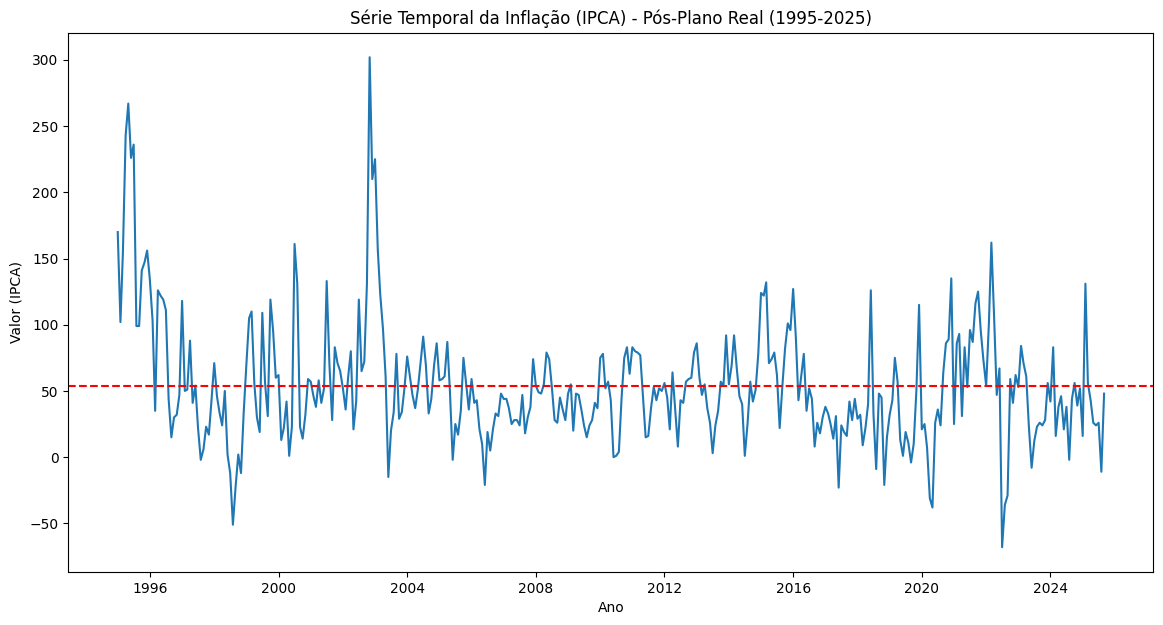

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(df_pos_real.index, df_pos_real['value'], label='IPCA (Pós-Real)')
plt.title('Série Temporal da Inflação (IPCA) - Pós-Plano Real (1995-2025)')
plt.xlabel('Ano')
plt.ylabel('Valor (IPCA)')

# Adicionar uma linha da média para referência
mean_value = df_pos_real['value'].mean()
plt.axhline(mean_value, color='red', linestyle='--', label=f'Média ({mean_value:.2f})')

-- **Não-Estacionariedade (Média)**: A série é **claramente não-estacionária** na média. Ela flutua em longos períodos acima ou abaixo (ex: o pico de 2003, o pico de 2015, o pico de 2021). Ela exibe o que parece ser um **"passeio aleatório"** (random walk), o que sugere que precisaremos de diferenciação (o "I" do ARIMA).

-- **Não-Estacionariedade (Variância)**: A série também parece heteroscedástica (não-estacionária na variância). A volatilidade é visivelmente maior no início do período (1995-2003) do que no período 2005-2019. Isso pode ser um desafio para modelos lineares como o ARIMA.

-- **Sazonalidade:** É difícil afirmar visualmente se há sazonalidade. Pode haver, mas ela está "escondida" pela tendência e pela volatilidade.


## **2.6 - Divisão de treino e teste**

Antes de qualquer análise (ADF, ACF, decomposição), iremos separar os dados. Vamos reservar os últimos 12 meses como nosso conjunto de teste. Toda a nossa análise e treinamento de modelos será feita apenas no conjunto de treino.

In [11]:
n_test = 12
train_data = df_pos_real.iloc[:-n_test]
test_data = df_pos_real.iloc[-n_test:]

print(f"--- Divisão dos Dados ---")
print(f"Total de observações (Pós-Real): {len(df_pos_real)}")
print(f"Dados de Treino: {len(train_data)} (de {train_data.index.min().date()} até {train_data.index.max().date()})")
print(f"Dados de Teste: {len(test_data)} (de {test_data.index.min().date()} até {test_data.index.max().date()})")

--- Divisão dos Dados ---
Total de observações (Pós-Real): 369
Dados de Treino: 357 (de 1995-01-01 até 2024-09-01)
Dados de Teste: 12 (de 2024-10-01 até 2025-09-01)


## **2.7 - Teste de Estacionariedade (ADF)**

A hipótese nula (H0) do ADF é que a série possui uma raiz unitária (é não-estacionária). Se o p-valor for alto (ex: > 0.05), falhamos em rejeitar a H0, e confirmamos que a série precisa de diferenciação.

In [12]:
print("--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---")
adf_result = adfuller(train_data['value'].dropna())
adf_pvalue = adf_result[1]
adf_stat = adf_result[0]

print(f'Estatística ADF: {adf_stat:.4f}')
print(f'p-valor: {adf_pvalue:.4f}')

if adf_pvalue > 0.05:
    print("Resultado: Falhamos em rejeitar H0. A série é NÃO-ESTACIONÁRIA.")
else:
    print("Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.")

--- Teste Dickey-Fuller Aumentado (ADF) na Série Original (Treino) ---
Estatística ADF: -5.0214
p-valor: 0.0000
Resultado: Rejeitamos H0. A série é ESTACIONÁRIA.


- Teste ADF: (p-valor < 0.05, imagino) disse: "A série é Estacionária".
- A Análise Visual mostrou uma série que "passeia" e não parece reverter a uma média fixa. Ela parece Não-Estacionária.
- O Teste ADF é um teste estatístico para raiz unitária. Em um período muito longo (1995-2024), é possível que a série tenha revertido à média o suficiente para "passar" no teste.
- MAS Para modelagem, a análise visual e, mais importante, a Análise de Autocorrelação (ACF), são mais importantes que o Teste ADF isolado.

## **2.8 - Decomposição da Série Temporal e Análise de Autocorrelação (ACF e PACF)**

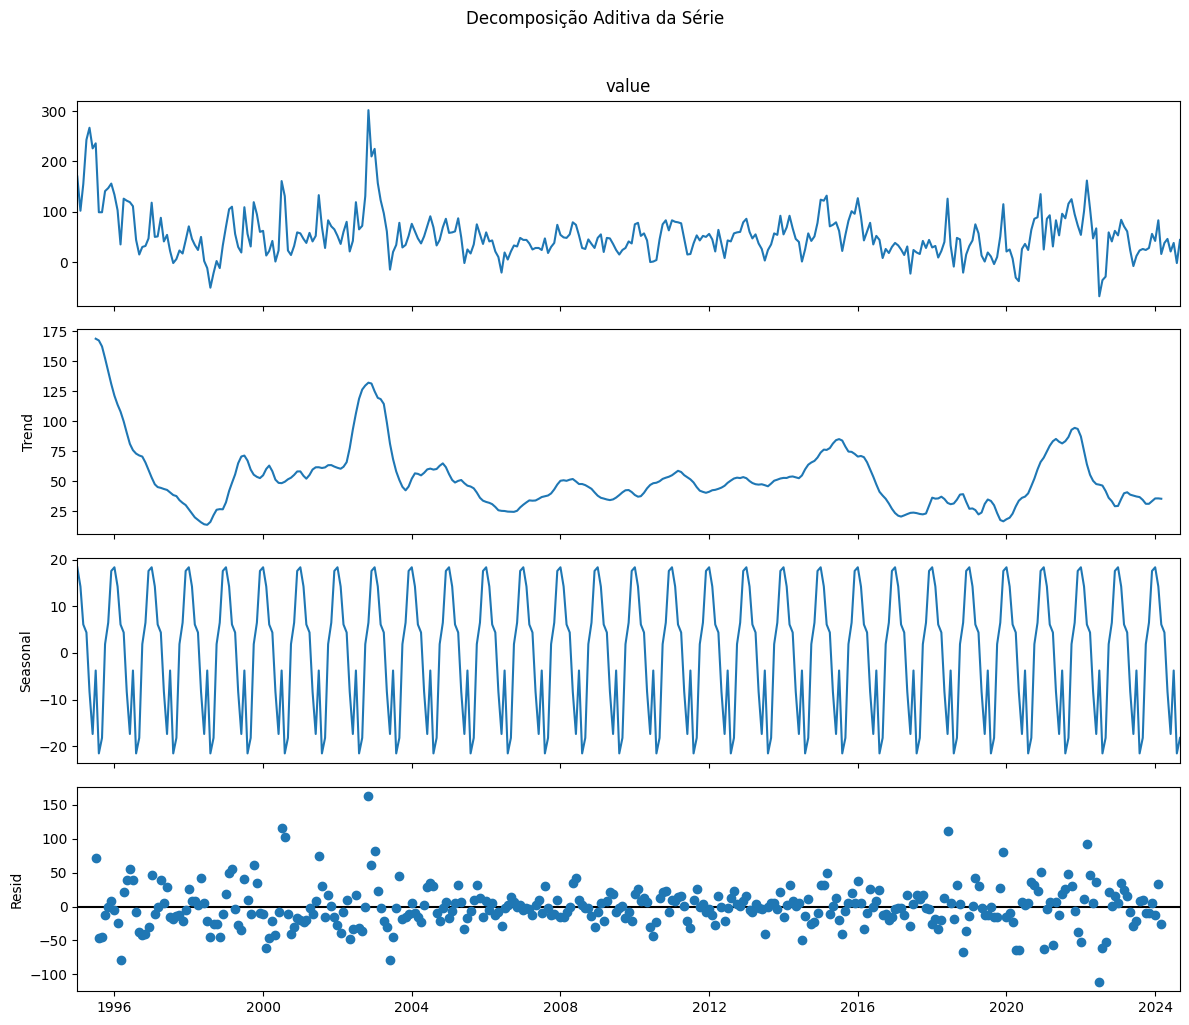

In [14]:
decomposition = seasonal_decompose(train_data['value'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle('Decomposição Aditiva da Série', y=1.02)
plt.tight_layout()

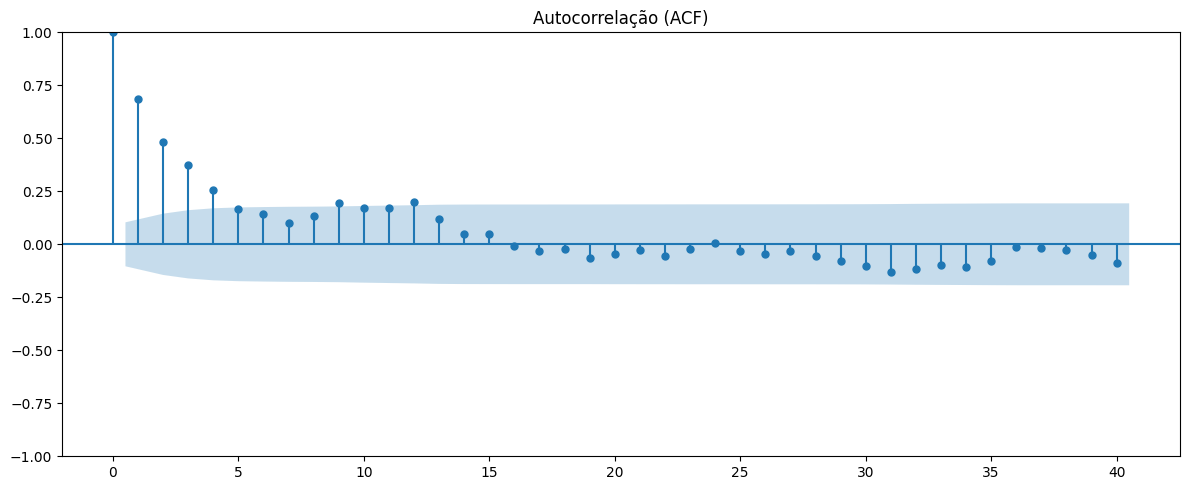

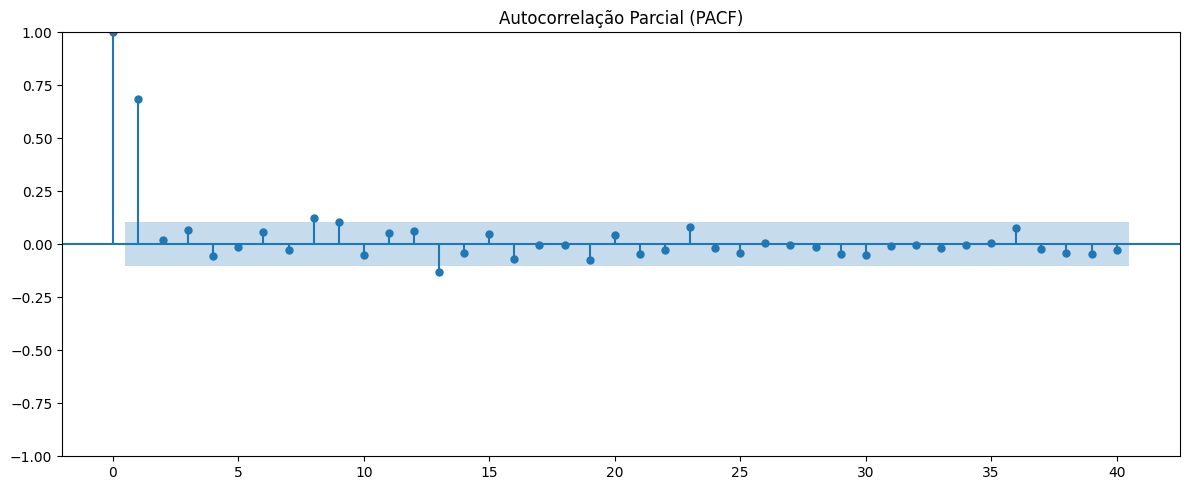

In [15]:
n_lags = 40

# ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação (ACF)')
plt.tight_layout()

# PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data['value'].dropna(), lags=n_lags, ax=ax, title='Autocorrelação Parcial (PACF)')
plt.tight_layout()

**1. Análise da Decomposição Aditiva**
- **Tendência:** A tendência não é uma linha reta; ela sobe, desce e sobe de novo. Isso é um forte indício de não-estacionariedade na média. A inflação não tem um "ponto central" fixo, ela "passeia" (random walk).

- **Sazonalidade (Seasonal):** Existe um padrão que se repete todo ano. Ele é pequeno comparado à tendência, mas é consistente.

- **Resíduo (Residual):** Notamos que ele é mais "grosso" (volátil) no início (pré-2005) e no final (pós-2021). Isso confirma a heteroscedasticidade (variância não-constante).

